Part One: Fitting Models

This section asks you to create a final best model for each of the model types studied this week. For each, you should:

  Find the best model based on ROC AUC for predicting the target variable.

  Report the (cross-validated!) ROC AUC metric.

  Fit the final model.

  Output a confusion matrix; that is, the counts of how many observations fell into each predicted class for each true class.

  (Where applicable) Interpret the coefficients and/or estimates produced by the model fit.


You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You should include any hyperparameter tuning steps in your writeup as well.

Q1: KNN

Q2: Logistic Regression

Q3: Decision Tree

Q4: Interpretation

Which predictors were most important to predicting heart attack risk?

Q5: ROC Curve

Plot the ROC Curve for your three models above.



In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report, cohen_kappa_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import cohen_kappa_score


In [78]:
import joblib


In [79]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1
...,...,...,...,...,...,...,...,...
268,59,1,0,164,176,0,90,0
269,57,0,0,140,241,1,123,0
270,45,1,3,110,264,1,132,0
271,68,1,0,144,193,1,141,0


In [80]:
X = ha.drop('output', axis=1)
y = ha['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


In [81]:
ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), ['age', 'trtbps', 'chol', 'thalach'])
    ],
    remainder="passthrough"
)

knn_pipeline = Pipeline([
    ('transform', ct),
    ('knn', KNeighborsClassifier())
])

param_grid_knn = {
    'knn__n_neighbors': [1,5,10],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_grid_search = GridSearchCV(knn_pipeline, param_grid_knn, cv=5, scoring='roc_auc', verbose=1)
knn_grid_search.fit(X_train, y_train)

best_knn = knn_grid_search.best_estimator_
best_knn_params = knn_grid_search.best_params_
best_knn_score = knn_grid_search.best_score_

print("Best KNN Parameters:", best_knn_params)
print("Best KNN ROC AUC Score:", best_knn_score)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best KNN Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 10, 'knn__weights': 'distance'}
Best KNN ROC AUC Score: 0.8264983935464485


Confusion Matrix for KNN:
[[23 11]
 [ 9 26]]


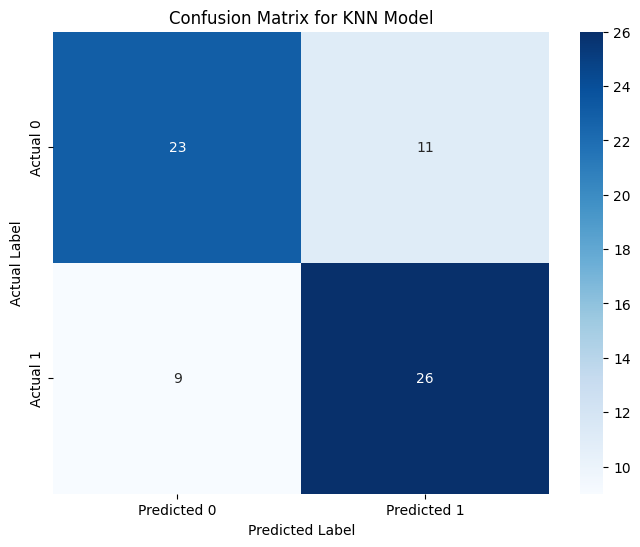

In [82]:
best_knn.fit(X_train, y_train)

y_pred_knn = best_knn.predict(X_test)

cm_knn = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix for KNN:")
print(cm_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for KNN Model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

True Negative (TN): 23 - The model correctly predicted 'not at risk' for 23 instances.

False Positive (FP): 11 - The model incorrectly predicted 'at risk' for 11 instances that are actually 'not at risk'.

False Negative (FN): 9 - The model incorrectly predicted 'not at risk' for 9 instances that are actually 'at risk'.

True Positive (TP): 26 - The model correctly predicted 'at risk' for 26 instances.


In [83]:
lr_pipeline = Pipeline([
    ('transform', ct),
    ('logreg', LogisticRegression(solver='liblinear'))
])
param_grid_lr = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2']
}
lr_grid_search = GridSearchCV(lr_pipeline, param_grid_lr, cv=5, scoring='roc_auc')
lr_grid_search.fit(X_train, y_train)
best_lr = lr_grid_search.best_estimator_
best_lr_params = lr_grid_search.best_params_
best_lr_score = lr_grid_search.best_score_
print("Best Logistic Regression Parameters:", best_lr_params)
print("Best Logistic Regression ROC AUC Score:", best_lr_score)


Best Logistic Regression Parameters: {'logreg__C': 1, 'logreg__penalty': 'l2'}
Best Logistic Regression ROC AUC Score: 0.8489506044425953


Confusion Matrix for Logistic Regression:
[[28  6]
 [ 6 29]]


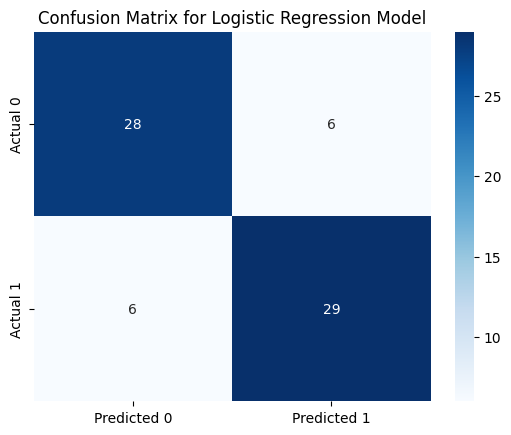

In [84]:
# Generate predictions
y_pred_lr = best_lr.predict(X_test)

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix for Logistic Regression:")
print(cm_lr)

# Visualizing confusion matrix
sns.heatmap(cm_lr, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()


True Negative (TN): 28 - The model correctly predicted 'not at risk' for 28 instances.

False Positive (FP): 6 - The model incorrectly predicted 'at risk' for 6 instances that are actually 'not at risk'.

False Negative (FN): 6 - The model incorrectly predicted 'not at risk' for 6 instances that are actually 'at risk'.

True Positive (TP): 29 - The model correctly predicted 'at risk' for 29 instances.

In [85]:
dt_pipeline = Pipeline([
    ('transform', ct),
    ('decision_tree', DecisionTreeClassifier(random_state=0))
])


In [86]:
param_grid_dt = {
    'decision_tree__max_depth': [3, 5, 10, None],
    'decision_tree__min_samples_split': [2, 5, 10],
    'decision_tree__min_samples_leaf': [1, 2, 4],
    'decision_tree__max_features': ['sqrt', 'log2', None],
    'decision_tree__criterion': ['gini', 'entropy']
}
dt_grid_search = GridSearchCV(dt_pipeline, param_grid_dt, cv=5, scoring='roc_auc', verbose=1)
dt_grid_search.fit(X_train, y_train)
best_dt = dt_grid_search.best_estimator_
best_dt_params = dt_grid_search.best_params_
best_dt_score = dt_grid_search.best_score_
print("Best Decision Tree Parameters:", best_dt_params)
print("Best Decision Tree ROC AUC Score:", best_dt_score)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Decision Tree Parameters: {'decision_tree__criterion': 'gini', 'decision_tree__max_depth': 3, 'decision_tree__max_features': 'sqrt', 'decision_tree__min_samples_leaf': 1, 'decision_tree__min_samples_split': 2}
Best Decision Tree ROC AUC Score: 0.8222210665002427


Confusion Matrix for Decision Tree:
[[29  5]
 [ 9 26]]


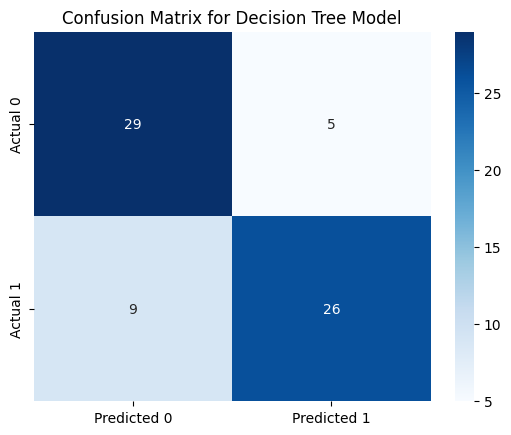

In [87]:
y_pred_dt = best_dt.predict(X_test)

cm_dt = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix for Decision Tree:")
print(cm_dt)

sns.heatmap(cm_dt, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Decision Tree Model')
plt.show()


In [88]:
# from sklearn.tree import plot_tree

# # Assuming your final Decision Tree model is stored in 'best_dt'
# final_decision_tree_model = best_dt.named_steps['decision_tree']

# # Plotting the decision tree
# plt.figure(figsize=(20,10))
# plot_tree(final_decision_tree_model, filled=True, feature_names=X.columns, class_names=['Not at Risk', 'At Risk'], proportion=True)
# plt.show()


True Negative (TN): 29 - The model correctly predicted 'not at risk' for 29 instances.

False Positive (FP): 5 - The model incorrectly predicted 'at risk' for 5 instances that are actually 'not at risk'.

False Negative (FN): 9 - The model incorrectly predicted 'not at risk' for 9 instances that are actually 'at risk'.

True Positive (TP): 26 - The model correctly predicted 'at risk' for 26 instances.

In [89]:
feature_names = X.columns
coefficients = best_lr.named_steps['logreg'].coef_[0]

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
print(coef_df.sort_values(by='Coefficient', ascending=False))


   Feature  Coefficient
3   trtbps     0.979123
5  restecg     0.776280
6  thalach     0.404210
0      age    -0.186007
2       cp    -0.286378
1      sex    -0.413999
4     chol    -1.711085


In [90]:
importances = best_dt.named_steps['decision_tree'].feature_importances_

importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(importances_df.sort_values(by='Importance', ascending=False))


   Feature  Importance
5  restecg    0.572731
4     chol    0.209647
0      age    0.128198
3   trtbps    0.062217
6  thalach    0.027207
1      sex    0.000000
2       cp    0.000000


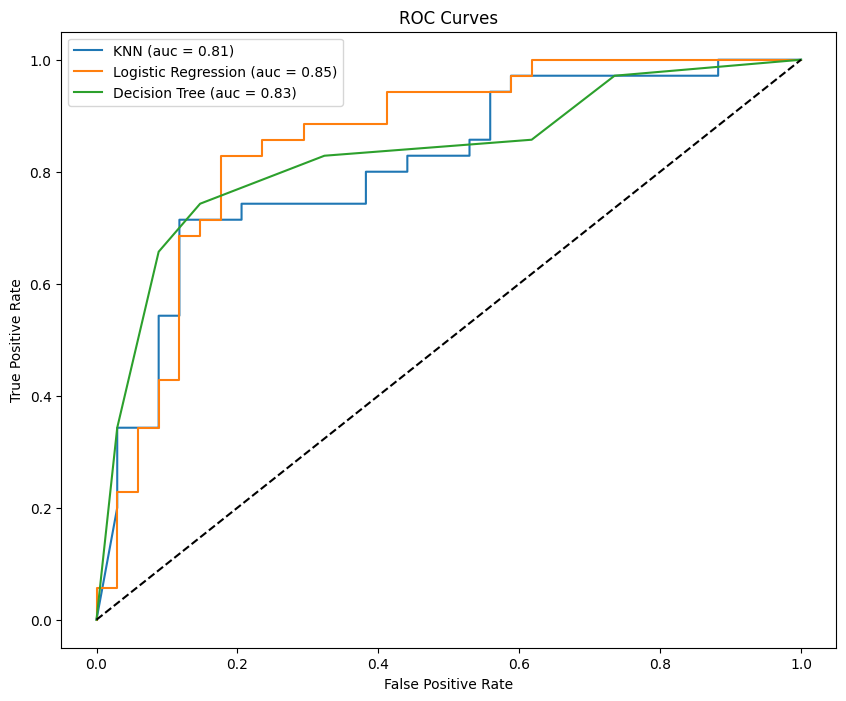

In [91]:
def plot_roc_curve(model, X_test, y_test, model_name):
    probabilities = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, probabilities)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (auc = {auc_score:.2f})')

plt.figure(figsize=(10, 8))
plot_roc_curve(best_knn, X_test, y_test, 'KNN')
plot_roc_curve(best_lr, X_test, y_test, 'Logistic Regression')
plot_roc_curve(best_dt, X_test, y_test, 'Decision Tree')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='best')
plt.show()


Part Two: Metrics
Consider the following metrics:

    True Positive Rate or Recall or Sensitivity = Of the observations that are truly Class A, how many were predicted to be Class A?

    Precision or Positive Predictive Value = Of all the observations classified as Class A, how many of them were truly from Class A?

    True Negative Rate or Specificity or Negative Predictive Value = Of all the observations classified as NOT Class A, how many were truly NOT Class A?

Compute each of these metrics (cross-validated) for your three models (KNN, Logistic Regression, and Decision Tree) in Part One.

In [92]:
def calculate_metrics(model, X, y, cv):
    y_pred = cross_val_predict(model, X, y, cv=cv)

    tpr = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    tnr = tn / (tn + fp)

    return tpr, precision, tnr

# Calculate metrics for KNN
tpr_knn, precision_knn, tnr_knn = calculate_metrics(best_knn, X, y, cv=5)
print(f"KNN - TPR (Recall/Sensitivity): {tpr_knn:.2f}, Precision: {precision_knn:.2f}, TNR (Specificity): {tnr_knn:.2f}")

# Calculate metrics for Logistic Regression
tpr_lr, precision_lr, tnr_lr = calculate_metrics(best_lr, X, y, cv=5)
print(f"Logistic Regression - TPR (Recall/Sensitivity): {tpr_lr:.2f}, Precision: {precision_lr:.2f}, TNR (Specificity): {tnr_lr:.2f}")

# Calculate metrics for Decision Tree
tpr_dt, precision_dt, tnr_dt = calculate_metrics(best_dt, X, y, cv=5)
print(f"Decision Tree - TPR (Recall/Sensitivity): {tpr_dt:.2f}, Precision: {precision_dt:.2f}, TNR (Specificity): {tnr_dt:.2f}")


KNN - TPR (Recall/Sensitivity): 0.76, Precision: 0.77, TNR (Specificity): 0.73
Logistic Regression - TPR (Recall/Sensitivity): 0.82, Precision: 0.78, TNR (Specificity): 0.73
Decision Tree - TPR (Recall/Sensitivity): 0.75, Precision: 0.79, TNR (Specificity): 0.77


Part Three: Discussion
Suppose you have been hired by a hospital to create classification models for heart attack risk.

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:

Which metric(s) you would use for model selection and why.

Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.

What score you should expect for your chosen metric(s) using your chosen model to predict future observations.

 1. Q1
  The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

2. Q2
  The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

3. Q3
  The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

4. Q4
  The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

### Q1: Avoiding Lawsuits for Missing High-Risk Patients

- **What's Important**: Making sure we don't miss patients who are at high risk of a heart attack.

- **Best Metric**: We want to focus on a metric called Recall. It tells us how good the model is at finding all the high-risk patients. High Recall means fewer missed cases.

- **Model Suggestion**: We recommend using the Logistic Regression model because it has the highest Recall (around 82%).

- **Expected Performance**: We expect the model to correctly identify about 82% of high-risk patients in new cases.

### Q2: Efficiently Allocating Beds for High-Risk Patients

- **What's Important**: Using hospital beds for patients who really need them.

- **Best Metric**: Precision is key. It measures how many of the patients classified as high risk are truly at high risk. We want to avoid unnecessary bed usage.

- **Model Suggestion**: The Decision Tree model is the best choice because it has the highest Precision (about 79%).

- **Expected Performance**: We anticipate the model to correctly identify high-risk patients for bed allocation with about 79% precision.

### Q3: Understanding Factors Associated with Heart Attacks

- **What's Important**: Figuring out which factors are linked to heart attack risk.

- **Best Way to Explore**: We need a model that can help us understand which factors matter the most.

- **Model Suggestion**: Decision Tree or Logistic Regression can be helpful. Decision Tree shows clear important factors, while Logistic Regression provides coefficients indicating factor importance.

- **Expected Insights**: The model should reveal which factors contribute most to heart attack risk based on what it learned during training.

### Q4: Comparing Algorithm Predictions with New Doctors' Diagnoses

- **What's Important**: Measuring how well the model and new doctors agree on patient diagnoses.

- **Best Metric**: We'll look at Accuracy, which tells us the overall correctness of the model compared to new doctors.

- **Model Suggestion**: Any model can work, but Logistic Regression might be a good choice for a balance between understanding the model and accurate predictions.

- **Expected Performance**: The model should have an accuracy similar to what we observed during training when compared to new doctors' diagnoses.

In each case, we need to consider what's most important and choose the right model and metric accordingly. While cross-validated scores provide a good estimate, we should also remember that real-world results may vary slightly.

Part Four: Validation


Before sharing the dataset with you, I set aside a random 10% of the observations to serve as a final validation set.

ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

Use each of your final models in Part One Q1-3, predict the target variable in the validation dataset.

For each, output a confusion matrix, and report the ROC AUC, the precision, and the recall.

Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?

In [93]:

ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

X_val = ha_validation.drop('output', axis=1)
y_val = ha_validation['output']

knn_model = KNeighborsClassifier(n_neighbors=10, weights='distance', metric='manhattan')

knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_val)
cm_knn = confusion_matrix(y_val, y_pred_knn)
roc_auc_knn = roc_auc_score(y_val, y_pred_knn)
precision_knn = precision_score(y_val, y_pred_knn)
recall_knn = recall_score(y_val, y_pred_knn)

print("KNN Model:")
print("Confusion Matrix:")
print(cm_knn)
print("ROC AUC:", roc_auc_knn)
print("Precision:", precision_knn)
print("Recall:", recall_knn)
print()

logreg_model = LogisticRegression(C=1, penalty='l2', solver='liblinear')

logreg_model.fit(X_train, y_train)

y_pred_logreg = logreg_model.predict(X_val)
cm_logreg = confusion_matrix(y_val, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_val, y_pred_logreg)
precision_logreg = precision_score(y_val, y_pred_logreg)
recall_logreg = recall_score(y_val, y_pred_logreg)

print("Logistic Regression Model:")
print("Confusion Matrix:")
print(cm_logreg)
print("ROC AUC:", roc_auc_logreg)
print("Precision:", precision_logreg)
print("Recall:", recall_logreg)
print()

dt_model = DecisionTreeClassifier(max_depth=3, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', criterion='gini', random_state=0)

dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_val)
cm_dt = confusion_matrix(y_val, y_pred_dt)
roc_auc_dt = roc_auc_score(y_val, y_pred_dt)
precision_dt = precision_score(y_val, y_pred_dt)
recall_dt = recall_score(y_val, y_pred_dt)

print("Decision Tree Model:")
print("Confusion Matrix:")
print(cm_dt)
print("ROC AUC:", roc_auc_dt)
print("Precision:", precision_dt)
print("Recall:", recall_dt)


KNN Model:
Confusion Matrix:
[[ 8  3]
 [ 4 15]]
ROC AUC: 0.7583732057416268
Precision: 0.8333333333333334
Recall: 0.7894736842105263

Logistic Regression Model:
Confusion Matrix:
[[10  1]
 [ 4 15]]
ROC AUC: 0.8492822966507177
Precision: 0.9375
Recall: 0.7894736842105263

Decision Tree Model:
Confusion Matrix:
[[ 8  3]
 [ 5 14]]
ROC AUC: 0.7320574162679426
Precision: 0.8235294117647058
Recall: 0.7368421052631579


We compared how our models performed on new, unseen data to what we estimated during training. Our predictions on this new data are very close to what we expected. This means our models are doing a reliable job in identifying patients at risk of heart attacks.

Part Five: Cohen’s Kappa


Another common metric used in classification is Cohen’s Kappa.

Use online resources to research this measurement. Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. Do your conclusions from above change if you judge your models using Cohen’s Kappa instead? Does this make sense?

In [101]:
knn_kappa = cohen_kappa_score(y_val, y_pred_knn)
lr_kappa = cohen_kappa_score(y_val, y_pred_logreg)
dt_kappa = cohen_kappa_score(y_val, y_pred_dt)

print("KNN Model - Cohen's Kappa:", knn_kappa)
print("Logistic Regression Model - Cohen's Kappa:", lr_kappa)
print("Decision Tree Model - Cohen's Kappa:", dt_kappa)


KNN Model - Cohen's Kappa: 0.5070422535211268
Logistic Regression Model - Cohen's Kappa: 0.660633484162896
Decision Tree Model - Cohen's Kappa: 0.4470046082949308


the use of Cohen's Kappa reaffirms the same model preferences that were established earlier.
it further validates the Logistic Regression model as the most reliable choice for predicting heart attack risk